In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [37]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [38]:
missing_data = dataset.isna().sum().sort_values()
missing_data

RID                            0
Gender                         0
Ageatscreening                 0
Diagnosis                      0
HipsSumAveragebaseline         1
MMSE0m                         3
ERCsASMbaseline                4
HipsSumVariancebaseline        7
HipsVariancebaseline           8
ERCsEntropybaseline            9
ERCsSumAveragebaseline        11
ERCsSumVariancebaseline       13
ERCsVariancebaseline          14
HipsContrastbaseline          14
ERCsVolumebaseline            14
ERCsContrastbaseline          18
HipsClusterShadebaseline      18
HipposcampusVolumebaseline    19
HipsCorelationbaseline        20
HipsEntropybaseline           23
HipsASMbaseline               25
ERCsCorelationbaseline        28
ERCsClusterShadebaseline      34
ERCs_thicknessbaseline        37
dtype: int64

In [39]:
# Step 1: split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((425, 23), (183, 23), (425,), (183,))

In [40]:
# Step 2: fill data temp using mean from training set
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_test.mean())

# Step 3: normalize features
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train_filled)
X_test_s = scaler.transform(X_test_filled)

In [41]:
tf.random.set_seed(42)

# Define Variational Autoencoder (VAE) function
def variational_autoencoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(124, activation="elu")(inputs)
    z_mean = layers.Dense(64)(x)
    z_log_var = layers.Dense(64)(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(sampling)([z_mean, z_log_var])
    
    # Decoder
    decoder = layers.Dense(126, activation="elu")(z)
    decoder = layers.Dense(64, activation="elu")(decoder)
    outputs = layers.Dense(input_dim, activation="linear")(decoder)
    
    vae = models.Model(inputs, outputs)
    return vae


In [42]:
# Step 5: Create and train the Variational Autoencoder (VAE)
input_dim = X_train_s.shape[1]  # Number of features
vae = variational_autoencoder(input_dim)

vae.compile(optimizer='adam', loss='mse')  # Mean squared error for reconstruction loss

# Train the VAE using the noisy training data
vae.fit(X_train_s, X_train_s, epochs=50, batch_size=50, validation_data=(X_test_s, X_test_s))

# Step 6: Get the reconstructed data from the VAE
X_train_reconstructed = vae.predict(X_train_s)
X_test_reconstructed = vae.predict(X_test_s)

# Step 7: Inverse transform the reconstructed data to the original scale
X_train_reconstructed_descaled = scaler.inverse_transform(X_train_reconstructed)
X_test_reconstructed_descaled = scaler.inverse_transform(X_test_reconstructed)

# Step 8: Convert the descaled numpy arrays back to pandas DataFrames
X_train_d = pd.DataFrame(X_train_reconstructed_descaled, columns=X_train_copy.columns)
X_test_d = pd.DataFrame(X_test_reconstructed_descaled, columns=X_test_copy.columns)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.7332 - val_loss: 0.2953
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2729 - val_loss: 0.1715
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1510 - val_loss: 0.1004
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0943 - val_loss: 0.0765
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0711 - val_loss: 0.0617
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0594 - val_loss: 0.0528
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0516 - val_loss: 0.0479
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0464 - val_loss: 0.0440
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0426 - val_loss: 0.0395
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0393 - val_loss: 0.0359
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0363 - val_loss: 0.0338
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0343 - val_loss: 0.0307
E

### Visualize

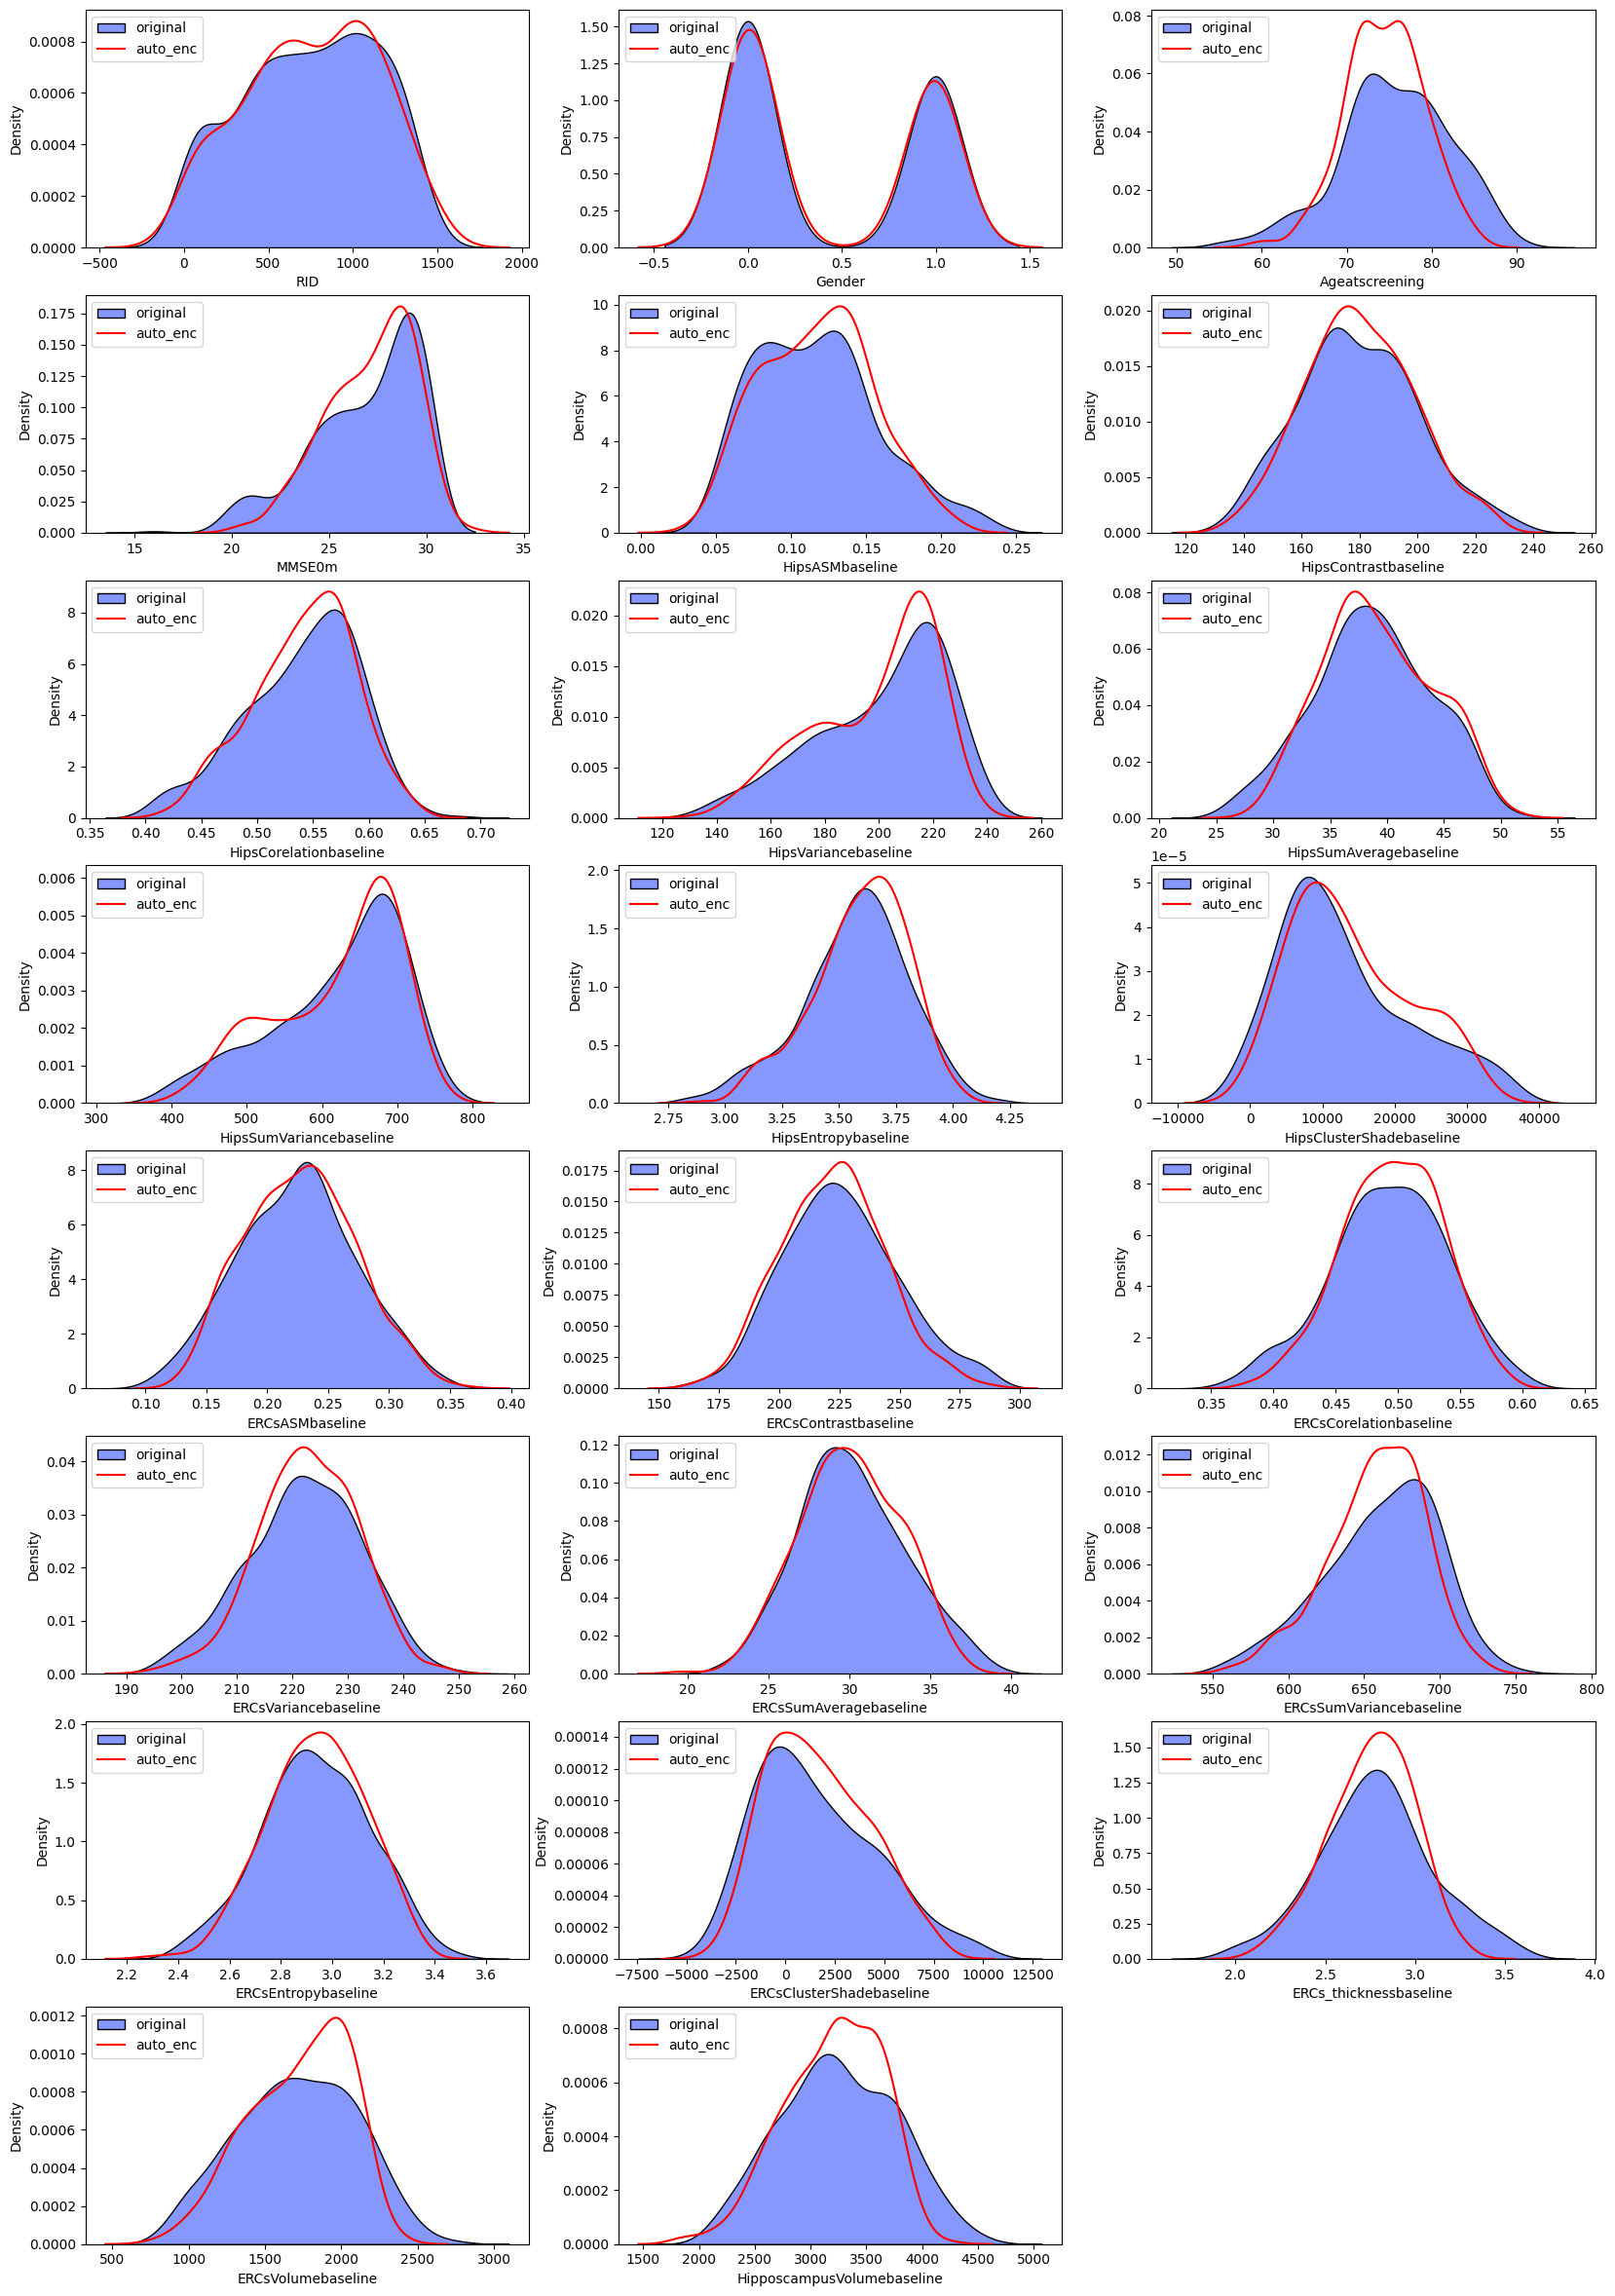

In [43]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_copy[X_train_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_d[X_train_d.columns[i]], color= "red")
    
    labels = ['original', 'auto_enc']
    plt.legend(labels, loc='upper left')

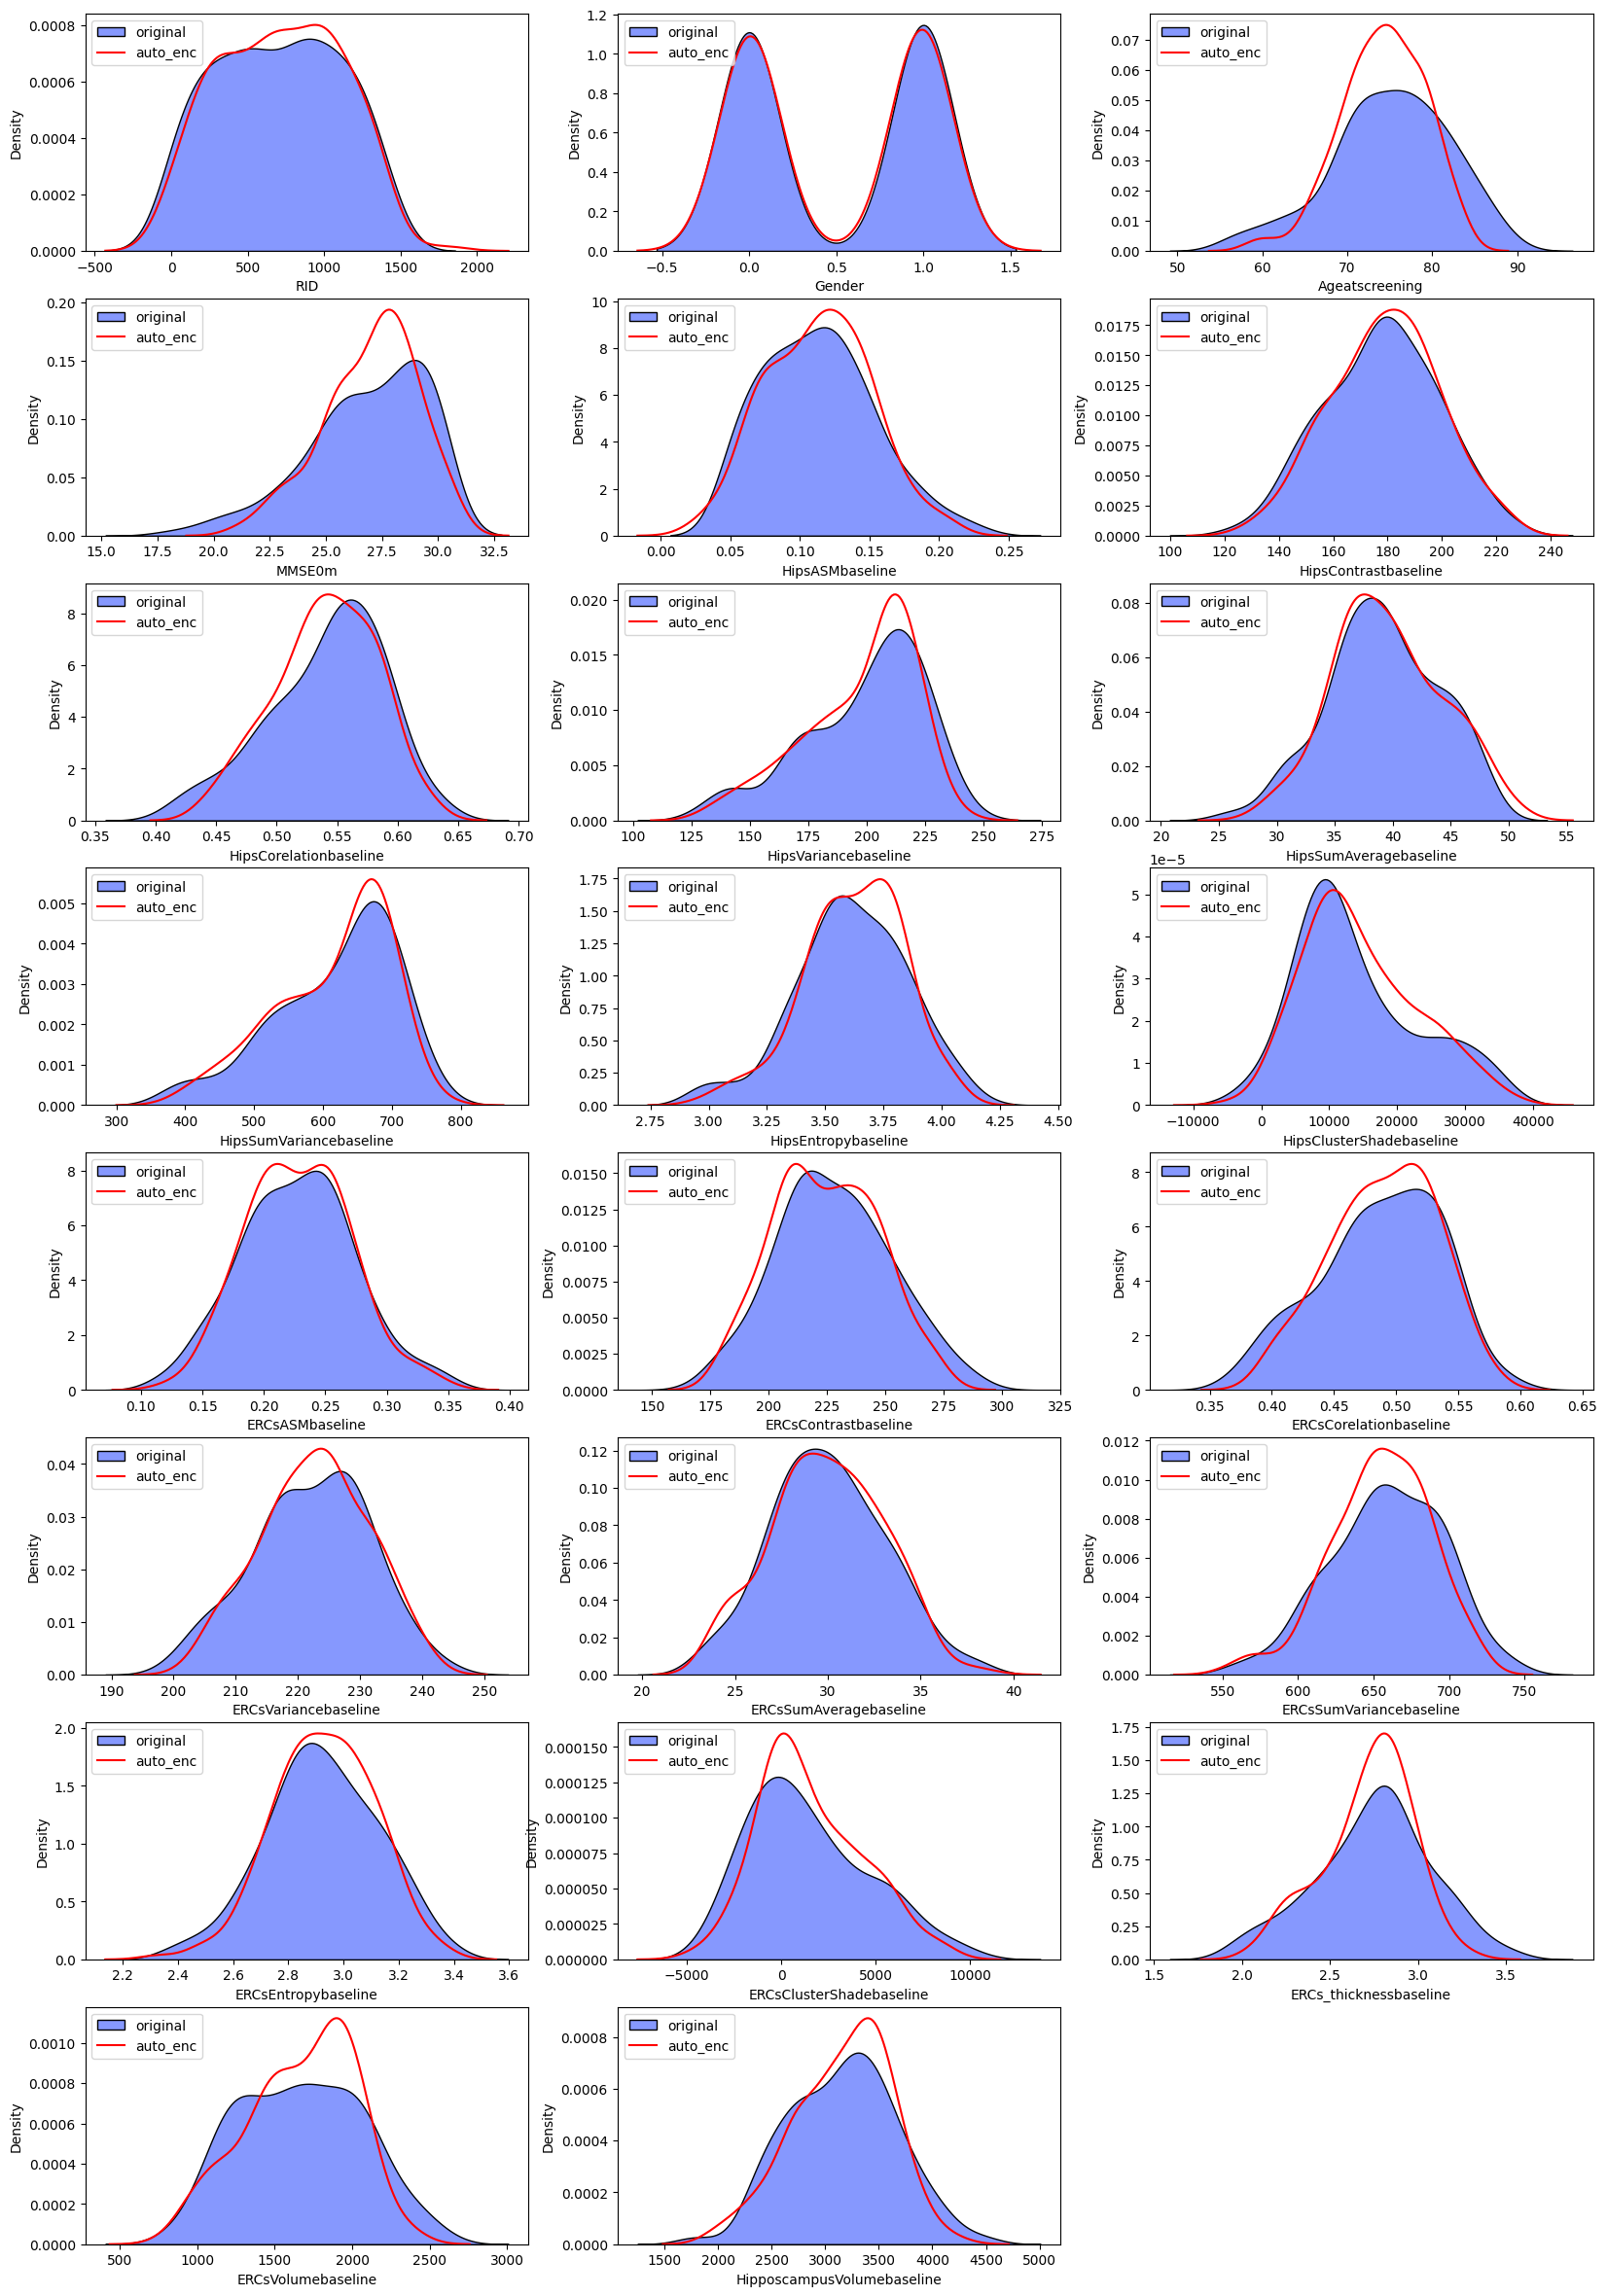

In [44]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_copy[X_test_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_d[X_test_d.columns[i]], color= "red")
    
    labels = ['original', 'auto_enc']
    plt.legend(labels, loc='upper left')

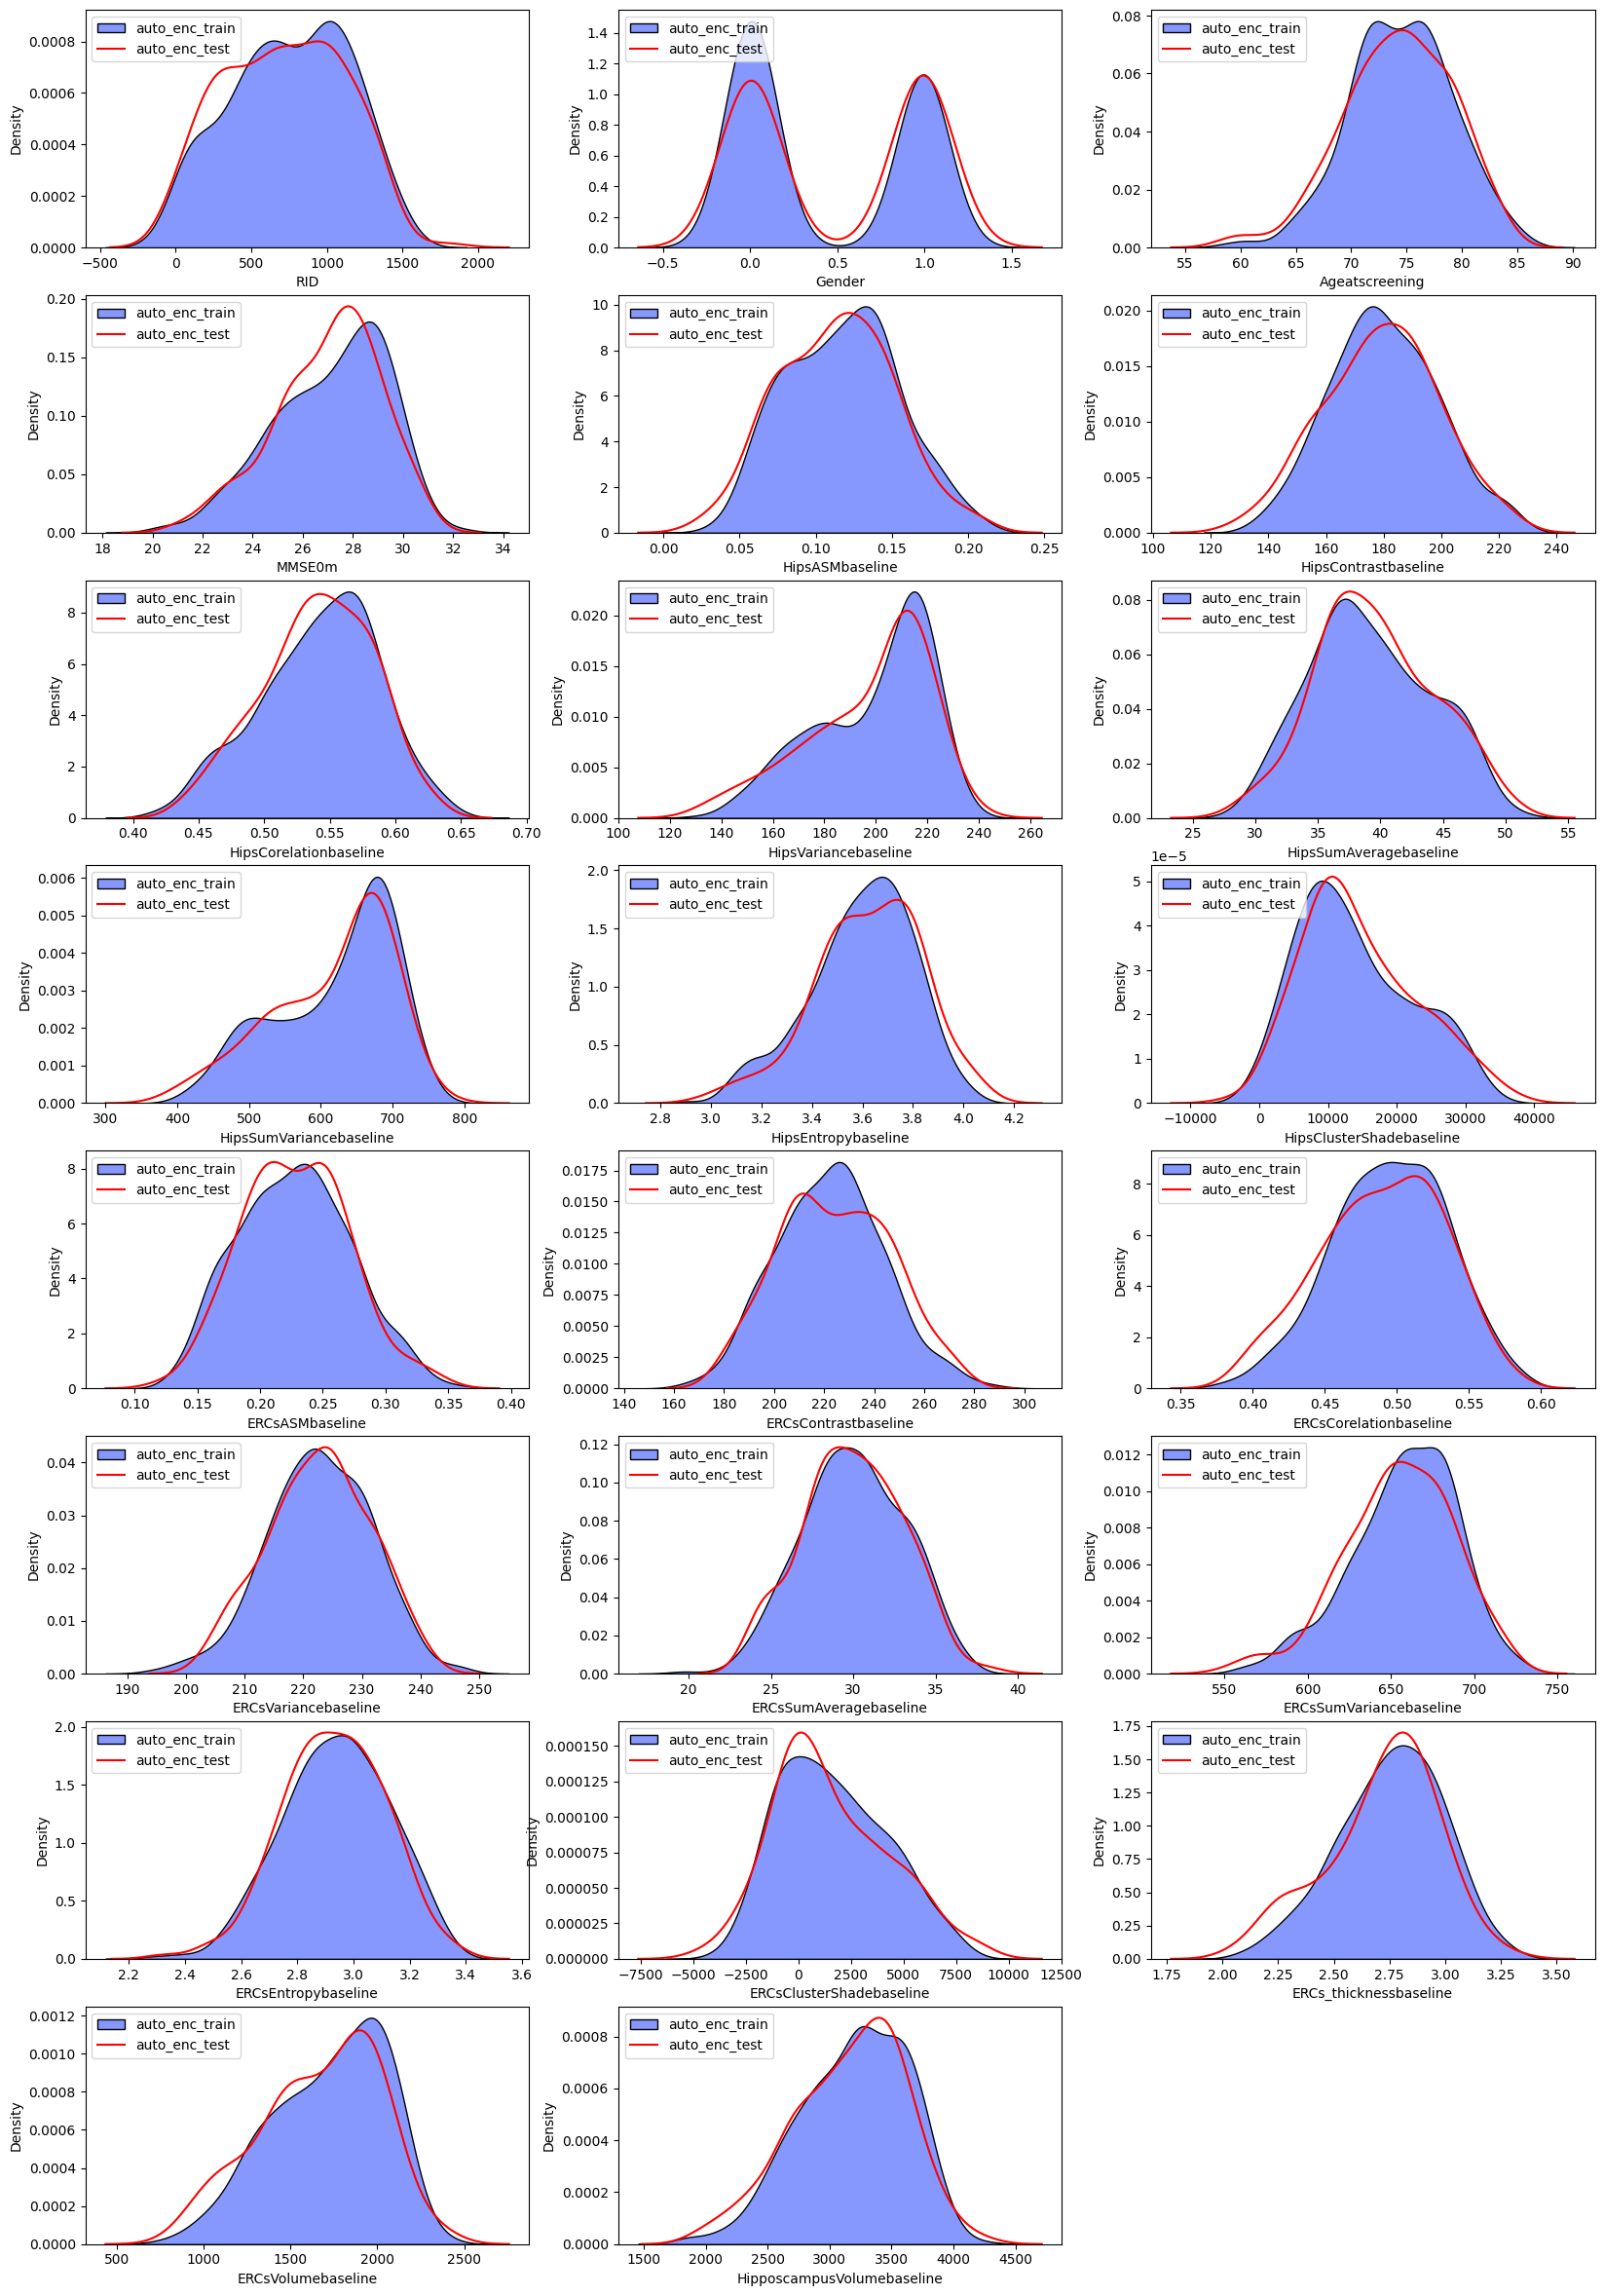

In [45]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_d[X_train_d.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_d[X_test_d.columns[i]], color= "red")
    
    labels = ['auto_enc_train', 'auto_enc_test']
    plt.legend(labels, loc='upper left')

### Validation Section

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score)

def run_random_forest(X_train, X_test, y_train, y_test):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Get predicted probabilities for ROC AUC
        pred_train_proba = rf.predict_proba(X_train)
        pred_test_proba = rf.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train_norm = rf.predict(X_train)
        pred_test_norm = rf.predict(X_test)
        
        # Calculate ROC-AUC
        roc_score_train = roc_auc_score(y_train, 
                                        pred_train_proba, 
                                        average="weighted", 
                                        multi_class="ovr",
        )
        roc_score_test = roc_auc_score(y_test,
                                    pred_test_proba,  
                                    average="weighted", 
                                    multi_class="ovr",
        )
        
        # Calculate accuracies
        accuracy_train = accuracy_score(y_train, pred_train_norm)
        accuracy_test = accuracy_score(y_test, pred_test_norm)
        
        # Print results
        print(f"Train ROC-AUC: {roc_score_train}")
        print(f"Train Accuracy: {accuracy_train}")
        print(f"Test ROC-AUC: {roc_score_test}")
        print(f"Test Accuracy: {accuracy_test}")
        
run_random_forest(X_train_d, X_test_d, y_train, y_test)

Train ROC-AUC: 0.9666052804234921
Train Accuracy: 0.8329411764705882
Test ROC-AUC: 0.768643186711896
Test Accuracy: 0.5300546448087432
